#Setup environment


In [0]:
#import plaidml.keras
#import os

# For using AMD GPU
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
#plaidml.keras.install_backend()

In [2]:
# Switch version to 2.x (works only in Colab)
%tensorflow_version 2.x 

TensorFlow 2.x selected.


In [0]:
#!pip install kaggle
#!mkdir -p ~/.kaggle

In [11]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"telemaco019","key":"02b9dc81900f80c86123a97b5fa5cc16"}'}

In [0]:
!rm ~/.kaggle -rf
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
!cat ~/.kaggle/kaggle.json

{"username":"telemaco019","key":"02b9dc81900f80c86123a97b5fa5cc16"}

In [14]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 98% 442M/450M [00:03<00:00, 153MB/s]
100% 450M/450M [00:03<00:00, 141MB/s]


In [15]:
!unzip /content/flowers-recognition.zip 

Streaming output truncated to the last 5000 lines.
  inflating: flowers/flowers/rose/11102341464_508d558dfc_n.jpg  
  inflating: flowers/flowers/rose/11233672494_d8bf0a3dbf_n.jpg  
  inflating: flowers/flowers/rose/11694025703_9a906fedc1_n.jpg  
  inflating: flowers/flowers/rose/118974357_0faa23cce9_n.jpg  
  inflating: flowers/flowers/rose/11944957684_2cc806276e.jpg  
  inflating: flowers/flowers/rose/12165480946_c4a3fe182d_n.jpg  
  inflating: flowers/flowers/rose/12202373204_34fb07205b.jpg  
  inflating: flowers/flowers/rose/12238827553_cf427bfd51_n.jpg  
  inflating: flowers/flowers/rose/12240165555_98625b1e88_n.jpg  
  inflating: flowers/flowers/rose/12240303_80d87f77a3_n.jpg  
  inflating: flowers/flowers/rose/12240577184_b0de0e53ea_n.jpg  
  inflating: flowers/flowers/rose/12243068283_ee4c2683e2_n.jpg  
  inflating: flowers/flowers/rose/12243069253_e512464095_n.jpg  
  inflating: flowers/flowers/rose/123128873_546b8b7355_n.jpg  
  inflating: flowers/flowers/rose/12323085443_8ac0

# Constants and imports


In [3]:
import glob
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from functools import partial 
import os 
import time

import pandas as pd
import seaborn

Using TensorFlow backend.


In [4]:
import tensorflow as tf
print(tf.__version__)

DATASET_ROOT_DIR = '/content/flowers'

DAISY_DIR = 'daisy'
DANDELION_DIR = 'dandelion'
ROSE_DIR = 'rose'
SUNFLOWER_DIR = 'sunflower'
TULIP_DIR = 'tulip'

DATA_DIRS = [DAISY_DIR, DANDELION_DIR, ROSE_DIR, SUNFLOWER_DIR, TULIP_DIR]

BATCH_SIZE = 32
IMG_SIZE = 224
SEED = 42
AUTOTUNE = tf.data.experimental.AUTOTUNE

2.1.0


# Load and prepare dataset

In [0]:
def load_data(dataset_directory): 
    images = []
    labels = []
    complete_directory = "{}/{}".format(DATASET_ROOT_DIR, dataset_directory)
    print('Loading data from: {}/'.format(complete_directory))

    for img_file in tqdm(os.listdir(complete_directory)):
        path = os.path.join(complete_directory, img_file)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if not img is None: 
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # change color channels order
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            images.append(np.array(img))
            labels.append(str(dataset_directory))
    
    return (np.array(images), np.array(labels))

In [0]:
encoder = LabelEncoder()
def encode_labels(string_labels):
    return encoder.fit_transform(string_labels)


In [0]:
def load_dataset():
    X = []
    Z = []
  
    for directory in DATA_DIRS:
        (data, labels_strings) = load_data(directory) 
        X.append(data)
        Z.append(labels_strings)
        
    # Squeeze into 1d array
    X = np.concatenate(X, axis=0)
    Z = np.concatenate(Z, axis=0)
    
    # Encode labels
    Y = encode_labels(Z)
    
    return (X,Y)

In [8]:
(X,Y) = load_dataset()

  0%|          | 0/769 [00:00<?, ?it/s]

Loading data from: /content/flowers/daisy/


  4%|▎         | 39/1055 [00:00<00:02, 387.69it/s]

Loading data from: /content/flowers/dandelion/


  5%|▍         | 39/784 [00:00<00:01, 374.07it/s]

Loading data from: /content/flowers/rose/


  5%|▌         | 39/734 [00:00<00:01, 380.03it/s]

Loading data from: /content/flowers/sunflower/


  5%|▍         | 46/984 [00:00<00:02, 457.95it/s]

Loading data from: /content/flowers/tulip/


100%|██████████| 984/984 [00:02<00:00, 421.13it/s]


In [9]:
print("Total number of images: {}".format(len(X)))
print("Total number of labels: {}".format(len(Y)))

Total number of images: 4323
Total number of labels: 4323


**Split train, valid and test datasets**

In [10]:
from sklearn import model_selection

X_train, X_test_valid, Y_train, Y_test_valid = model_selection.train_test_split(X,Y, train_size=0.75)
X_valid, X_test, Y_valid, Y_test = model_selection.train_test_split(X_test_valid, Y_test_valid, train_size=0.75)

print("Training dataset size: {}".format(len(X_train)))
print("Validation dataset size: {}".format(len(X_valid)))
print("Test dataset size: {}".format(len(X_test)))

Training dataset size: 3242
Validation dataset size: 810
Test dataset size: 271


# Utility functions


## Plot

In [0]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(12,10))
  class_names = encoder.inverse_transform(label_batch)
  for n in range(9):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image_batch[n])
      plt.title("Class: {}".format(class_names[n]))
      plt.axis('off')

In [0]:
import matplotlib.pyplot as plt

def plot_accuracy_curves(history):  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

In [0]:
def plot_correct_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  correct_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] == Y_test[i]:
      correct_pred_indexes.append(i)

  img_batch = [X_test[i] for i in correct_pred_indexes]
  lbl_batch = [Y_pred[i] for i in correct_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Correct predictions: {} out of {}".format(len(correct_pred_indexes), len(Y_test)))

In [0]:
def plot_wrong_predictions(model):
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()

  wrong_pred_indexes = []
  for i in range(0, len(Y_pred)): 
    if Y_pred[i] != Y_test[i]:
      wrong_pred_indexes.append(i)

  img_batch = [X_test[i] for i in wrong_pred_indexes]
  lbl_batch = [Y_pred[i] for i in wrong_pred_indexes]
  
  # shuffle
  indexes = np.arange(0, len(img_batch))
  np.random.shuffle(indexes)
  img_batch = [img_batch[i] for i in indexes]
  lbl_batch = [lbl_batch[i] for i in indexes]

  show_batch(img_batch, lbl_batch)
  print("Wrong predictions: {} out of {}".format(len(wrong_pred_indexes), len(Y_test)))

## Training

In [0]:
def get_early_stopping_callbacks(patience, checkpoint_file_path):
  # Early stopping + save best model callbacks 
  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_file_path, save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
  callbacks = [checkpoint_cb, early_stopping_cb]
  return callbacks

In [0]:
def train_model(model, epochs, callbacks):
  STEP_SIZE_TRAIN=len(X_train)//BATCH_SIZE
  STEP_SIZE_VALID=len(X_valid)//BATCH_SIZE

  print("Batch size: {}".format(BATCH_SIZE))
  print("Training dataset size: {} - Training steps per epoch: {}".format(len(X_train), STEP_SIZE_TRAIN))
  print("Validation dataset size: {} - Validation steps per epoch: {}".format(len(X_valid), STEP_SIZE_TRAIN))

  history = model.fit(train_dataset,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data=valid_dataset,
                      validation_steps=STEP_SIZE_VALID,
                      epochs=epochs,
                      callbacks = callbacks)
  
  return history

## Metrics

In [0]:
def show_scores(model):
  start = time.time()
  Y_pred_prob = model.predict(test_dataset, steps=len(Y_test))
  Y_pred = np.argmax(Y_pred_prob, axis=1).tolist()
  end = time.time()

  precision_micro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  precision_macro = metrics.precision_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  recall_micro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  recall_macro = metrics.recall_score(y_pred=Y_pred, y_true=Y_test, average='macro')
  f1_micro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='micro')
  f1_macro = metrics.f1_score(y_pred=Y_pred, y_true=Y_test, average='macro')

  plt.figure(figsize = (10,7))
  norm_cm = metrics.confusion_matrix(y_true=Y_test, y_pred=Y_pred, normalize='true')
  norm_cm_df = pd.DataFrame(norm_cm, index=encoder.classes_, columns=encoder.classes_)
  seaborn.heatmap(norm_cm_df, annot=True)

  print('|Average prediction time: {:.2f} ms'.format((end-start)/len(Y_test)*1000))
  print('|Average Type |Prec |Rec |F1')
  print('|--- |--- |--- |---') 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Micro', precision_micro, recall_micro, f1_micro)) 
  print("|{}|{:.2f}|{:.2f}|{:.2f}".format('Macro', precision_macro, recall_macro, f1_macro))

## Preprocessing



In [0]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

In [0]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

In [0]:
def preprocess(image, label, augmentation=False):
  if augmentation:
    cropped_image = random_crop(image)
    cropped_image = tf.image.random_flip_left_right(cropped_image)
    cropped_image = tf.image.random_flip_up_down(cropped_image)
    cropped_image = tf.image.random_brightness(cropped_image, max_delta=0.2)
  else:
    cropped_image = central_crop(image)
  
  resized_image = tf.image.resize(cropped_image, [IMG_SIZE, IMG_SIZE])
  normalized_image = tf.image.per_image_standardization(resized_image)
  
  return normalized_image,label

In [0]:
def apply_cache(labeled_dataset, cache=True, batch_size=BATCH_SIZE):
  # Load the dataset once and keep it in memory.
  # Use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory (in this case a file will be used as cache).
  if isinstance(cache, str):
    labeled_dataset = labeled_dataset.cache(cache)
  else:
    labeled_dataset = labeled_dataset.cache()

  return labeled_dataset

In [0]:
def batch_and_prefetch(labeled_dataset, batch_size=BATCH_SIZE, buffer_size=AUTOTUNE):
  return labeled_dataset.batch(batch_size).prefetch(buffer_size)

# Create Tensorflow datasets

In [0]:
unprocessed_train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
unprocessed_valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
unprocessed_test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [0]:
cached_train_dataset = apply_cache(unprocessed_train_dataset)
cached_valid_dataset = apply_cache(unprocessed_valid_dataset)

In [26]:
test_dataset = unprocessed_test_dataset.map(partial(preprocess, augmentation=False), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE).batch(1)

valid_dataset = cached_valid_dataset.map(partial(preprocess, augmentation=False))
valid_dataset = batch_and_prefetch(valid_dataset)

train_dataset = cached_train_dataset.shuffle(buffer_size=1000).repeat().map(partial(preprocess, augmentation=True), num_parallel_calls=AUTOTUNE)
train_dataset = batch_and_prefetch(train_dataset)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


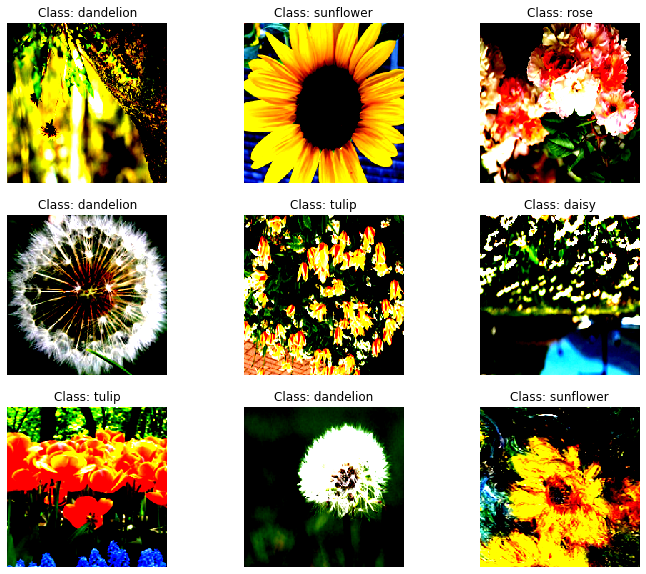

In [27]:
a, b = next(iter(train_dataset))
show_batch(a,b)

# Training from scratch

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [29]:
conv_base = InceptionV3(include_top=False, pooling='max', weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), layers=tf.keras.layers)
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [31]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [32]:
epochs = 40
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/40
101/101 [==============================] - 51s 505ms/step - loss: 1.6134 - accuracy: 0.4152 - val_loss: 1.6614 - val_accuracy: 0.2200
Epoch 2/40
101/101 [==============================] - 33s 330ms/step - loss: 1.3639 - accuracy: 0.4947 - val_loss: 1.6961 - val_accuracy: 0.2225
Epoch 3/40
101/101 [==============================] - 35s 347ms/step - loss: 1.2923 - accuracy: 0.5415 - val_loss: 1.3085 - val_accuracy: 0.4387
Epoch 4/40
101/101 [==============================] - 34s 334ms/step - loss: 1.2512 - accuracy: 0.5588 - val_loss: 1.4893 - val_accuracy: 0.5612
Epoch 5/40
101/101 [==============================] - 34s 332ms/step - loss: 1.1427 - accuracy: 0.5891 - val_loss: 2.0261 - val_accuracy: 0.5725
Epoch 6/40
101/101 [==============================] - 34s 334ms/step - loss: 1.0570 - accuracy

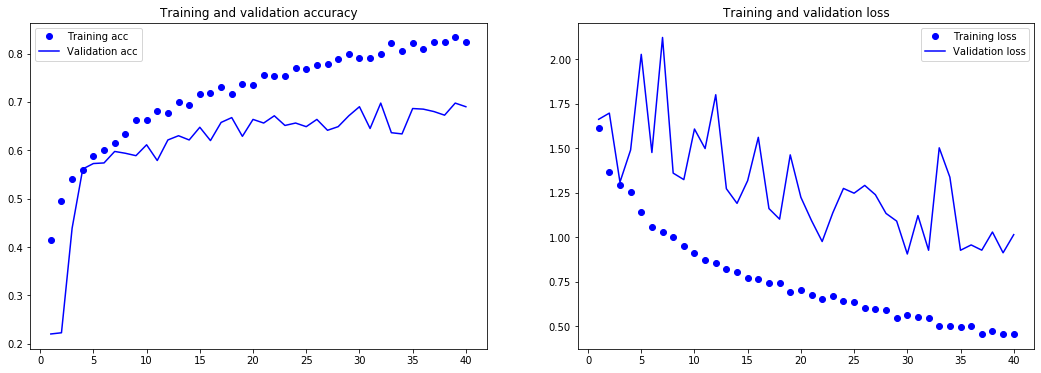

|Average prediction time: 28.08 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.77|0.77|0.77
|Macro|0.77|0.77|0.77


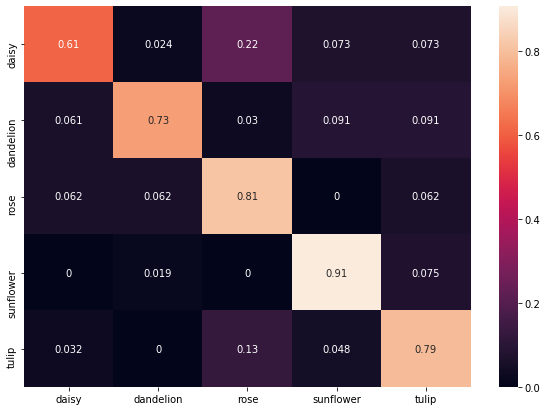

In [33]:
plot_curves(history)
show_scores(model)

# Feature extraction with Dense hidden layer and GlobalMaxPooling

> Indented block




In [0]:
# Use layers=tf.keras.layers in order to fix Keras bug. See https://github.com/keras-team/keras/pull/9965
conv_base = InceptionV3(weights="imagenet", include_top=False, pooling='avg', input_shape=(IMG_SIZE,IMG_SIZE,3), layers=tf.keras.layers)

for layer in conv_base.layers:
  layer.trainable = False

conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_940 (Conv2D)             (None, 111, 111, 32) 864         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_940 (BatchN (None, 111, 111, 32) 96          conv2d_940[0][0]                 
__________________________________________________________________________________________________
activation_940 (Activation)     (None, 111, 111, 32) 0           batch_normalization_940[0][0]    
_______________________________________________________________________________________

In [0]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(conv_base)
model.add(Dense(5, activation='softmax'))

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [0]:
epochs = 30
callbacks = get_early_stopping_callbacks(5, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/30
101/101 [==============================] - 17s 168ms/step - loss: 1.5231 - accuracy: 0.3438 - val_loss: 1.3089 - val_accuracy: 0.4875
Epoch 2/30
101/101 [==============================] - 11s 106ms/step - loss: 1.1448 - accuracy: 0.5560 - val_loss: 1.0712 - val_accuracy: 0.6025
Epoch 3/30
101/101 [==============================] - 11s 104ms/step - loss: 0.9657 - accuracy: 0.6426 - val_loss: 0.9501 - val_accuracy: 0.6525
Epoch 4/30
101/101 [==============================] - 10s 103ms/step - loss: 0.8904 - accuracy: 0.6723 - val_loss: 0.8769 - val_accuracy: 0.6812
Epoch 5/30
101/101 [==============================] - 10s 104ms/step - loss: 0.8077 - accuracy: 0.7113 - val_loss: 0.8283 - val_accuracy: 0.6925
Epoch 6/30
101/101 [==============================] - 10s 103ms/step - loss: 0.7642 - accuracy

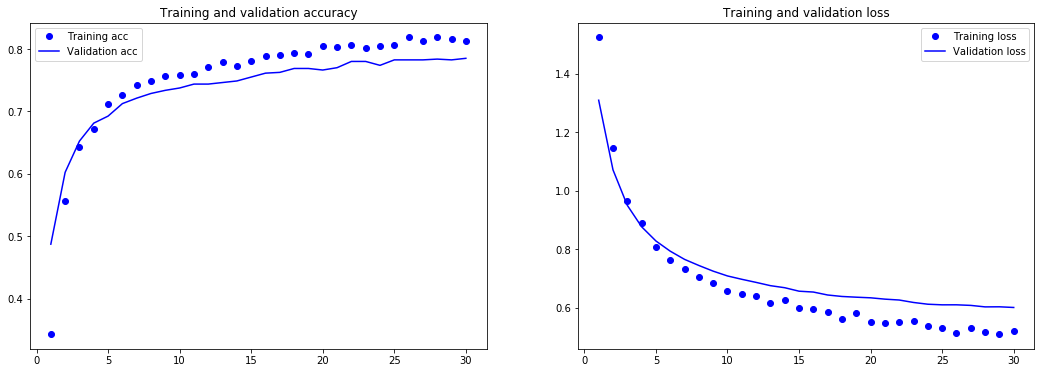

|Average prediction time: 19.94 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.76|0.76|0.76
|Macro|0.76|0.76|0.76


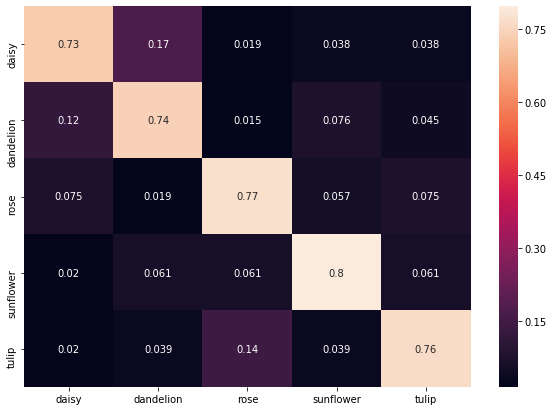

In [0]:
plot_curves(history)
show_scores(model)

# Fine tuning

In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
# in other examples found it was 172 insted 249. 
# I took 249 according to https://keras.io/applications/#inceptionv3
for layer in conv_base.layers[:249]:
    layer.trainable = False
for layer in conv_base.layers[249:]:
    layer.trainable = True

In [0]:
# Compile with lower learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 11,125,125
Non-trainable params: 10,687,904
_________________________________________________________________


In [0]:
epochs = 100
callbacks = get_early_stopping_callbacks(10, 'tf_flowers_augmented.h5')
history = train_model(model, epochs, callbacks)

Batch size: 32
Training dataset size: 3242 - Training steps per epoch: 101
Validation dataset size: 810 - Validation steps per epoch: 101
Train for 101 steps, validate for 25 steps
Epoch 1/100
101/101 [==============================] - 21s 209ms/step - loss: 0.7598 - accuracy: 0.7494 - val_loss: 0.5966 - val_accuracy: 0.7812
Epoch 2/100
101/101 [==============================] - 12s 121ms/step - loss: 0.5913 - accuracy: 0.8048 - val_loss: 0.5784 - val_accuracy: 0.7850
Epoch 3/100
101/101 [==============================] - 12s 123ms/step - loss: 0.5349 - accuracy: 0.8184 - val_loss: 0.5592 - val_accuracy: 0.8037
Epoch 4/100
101/101 [==============================] - 12s 123ms/step - loss: 0.4783 - accuracy: 0.8407 - val_loss: 0.5408 - val_accuracy: 0.8100
Epoch 5/100
101/101 [==============================] - 12s 121ms/step - loss: 0.4470 - accuracy: 0.8478 - val_loss: 0.5242 - val_accuracy: 0.8100
Epoch 6/100
101/101 [==============================] - 12s 121ms/step - loss: 0.4082 - ac

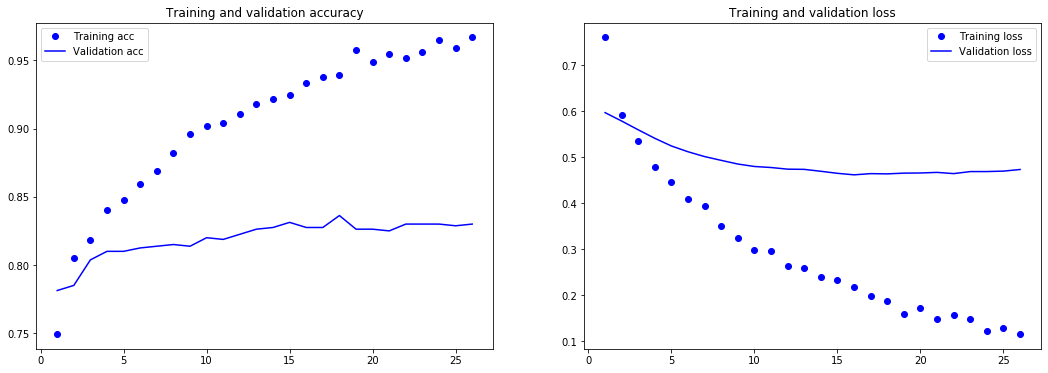

|Average prediction time: 18.65 ms
|Average Type |Prec |Rec |F1
|--- |--- |--- |---
|Micro|0.83|0.83|0.83
|Macro|0.83|0.83|0.83


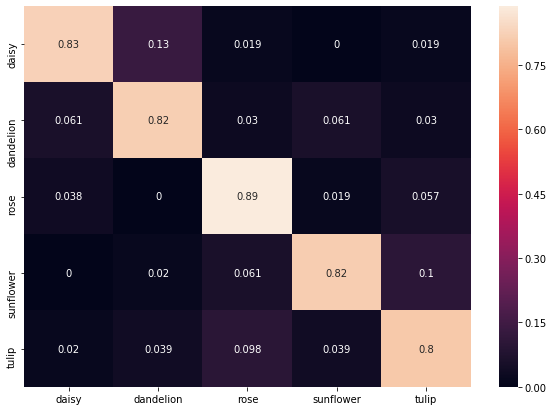

In [0]:
plot_curves(history)
show_scores(model)

# Visualize predictions on test set

Correct predictions: 229 out of 271


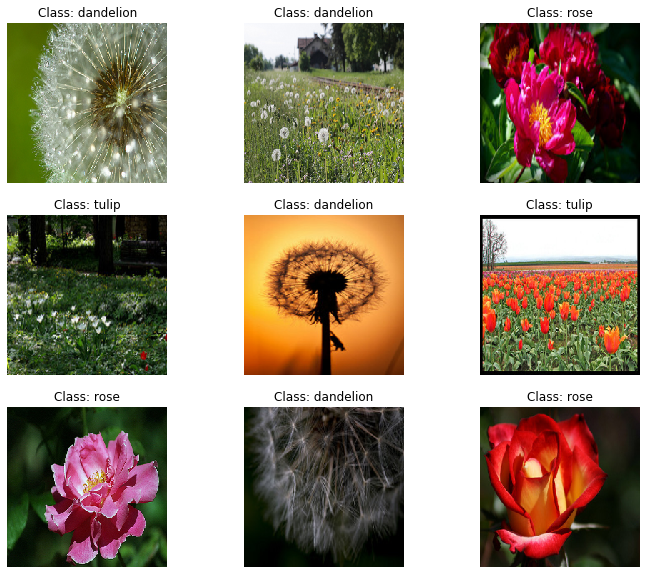

In [0]:
plot_correct_predictions(model)

Wrong predictions: 42 out of 271


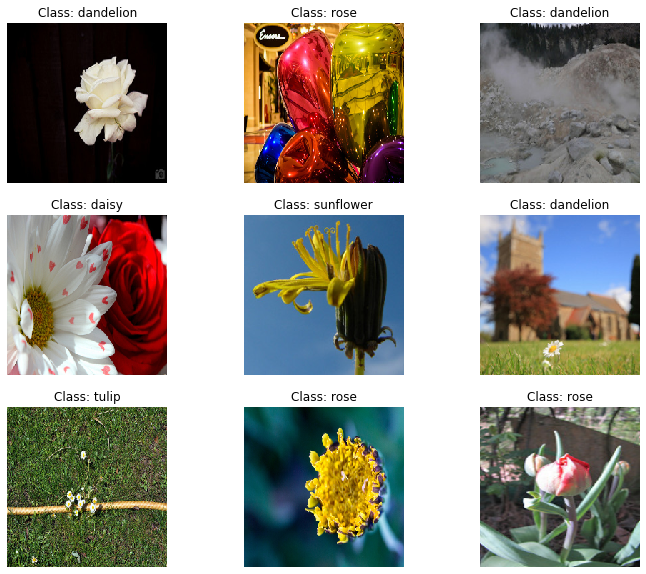

In [0]:

plot_wrong_predictions(model)